# Cancer Detection Challenge

Tyler Beisel

DTSA 5511 - CU Boulder

Summer 1

## The Challenge

The goal of this kaggle competition is to identify metastatic cancer in small image patches taken from larger digital pathology scans. This is a classic binary image classification task that has become very popular as an entry way to computer vision. 

Just from reading the challenge description, we can see a few things. 
1. The dataset is very large. There are 220,505 images for training / validating
2. Each image is 96x96x3
3. The dataset is in an easy to access format, with a csv determining which images contain cancer and which images are normal. 

The test dataset contains 57,458 images and should be submitted in the form of a csv

## Set-up and Exploratory Data Analysis

First, we import the packages that are needed.

In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
import tqdm

import keras.backend as K
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Next, we can read in the data and do some simple EDA.

In [44]:
full_train_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [45]:
full_train_df = shuffle(full_train_df).reset_index()
full_train_df.head()

,index,id,label
0,104327,439edb2f1c400c9b7eacc066baf6d9317dccc6cc,1
1,174625,9ca5f3cae944b0993d786c2913d30ff4d547f422,0
2,167736,d8024d845b1b279b6251d99715834fd96e69069c,1
3,145530,4c79da5a3f272bcb9e7a54be1ff3300549893600,1
4,10138,fc73aba73e146404abf9d1b790f055591a1495b7,0


In [46]:
full_train_df['label'].value_counts(normalize=True)

0    0.594969
1    0.405031
Name: label, dtype: float64

In [47]:
len([full_train_df['label']])

220025

<BarContainer object of 2 artists>

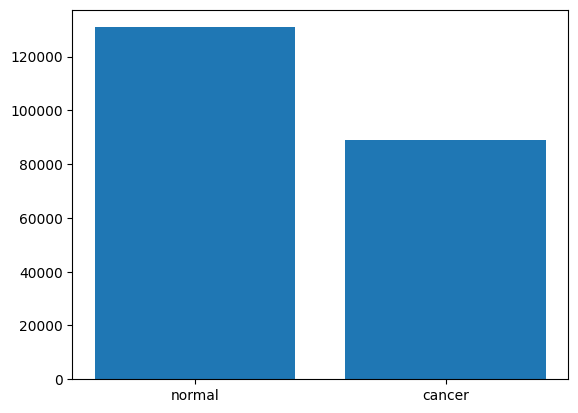

In [50]:
plt.bar(["normal", "cancer"], full_train_df['label'].value_counts())

As you can see, our data is fairly balanced, with 59.5% of the data being negative and 40.5% of the data being positive. This is not too large of an imbalance where I feel the need to under or oversample

## Data Cleaning

Next, I will clean the data by preparing it to be read in by Keras. The format that Keras expects is folder with subdirectories for each class containing all of the images for that class. 

In [8]:
os.mkdir('/kaggle/working/data')
os.mkdir('/kaggle/working/data/1/')
os.mkdir('/kaggle/working/data/0/')

The block of code below can be time consuming to run due to the very large size of the dataset.

In [ ]:

for img_id, label in tqdm.tqdm(zip(full_train_df['id'], full_train_df['label'])):
    img = cv2.imread('/kaggle/input/histopathologic-cancer-detection/train/{}.tif'.format(img_id))
    if label == 1:
        cv2.imwrite('/kaggle/working/data/1/{}.jpg'.format(img_id), img)
    else:
        cv2.imwrite('/kaggle/working/data/0/{}.jpg'.format(img_id), img)

We are now ready to visualize some of our images. We can confirm that the size of the images are 96x96x3

(96, 96, 3)


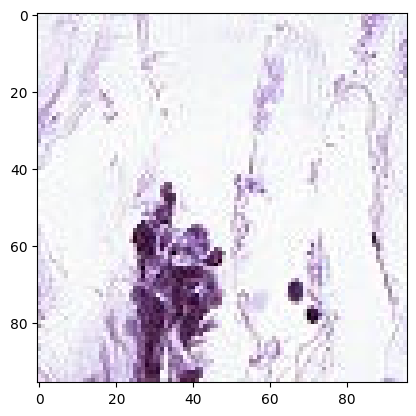

In [18]:
img = cv2.imread('/kaggle/input/histopathologic-cancer-detection/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif')
print(img.shape)
plt.imshow(img)

In [19]:
image_size = (96, 96)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/data",
    validation_split=0.2,
    subset="both",
    seed=22,
    image_size=image_size,
    batch_size=batch_size,
)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Using 44005 files for validation.


The block above creates the Keras dataset. There 176020 images in our training dataset and 44005 images in our validation dataset

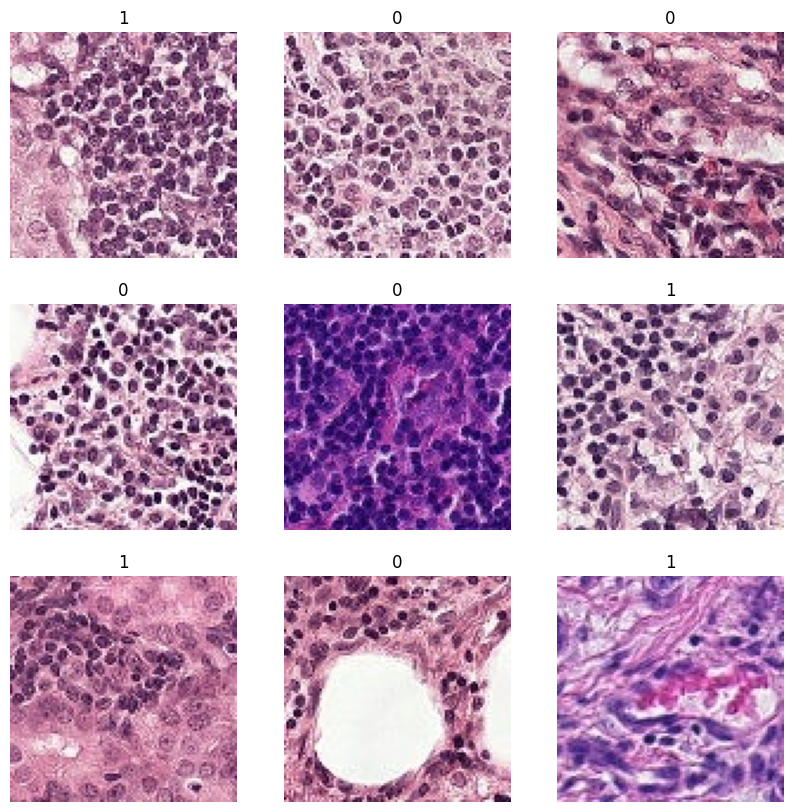

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Model Experimentation

For this challenge, I want to try out 3 different architectures.
1. A very simple CNN
2. A larger CNN
3. A larger CNN with a larger fully connected classifier

My purpose for this challenge is to learn more about building CNNs from scratch. This is why I have chosen these 3 architectures. These 3 architectures are building blocks to understanding the state of the art solutions and how modern CNNs are built. I am sure that I could obtain better results by conducting transfer learning on a state of the art image classification model from tf.hub, but that would not help me understand how to build these models from scratch. 

### The Simple CNN

For my first model, I will experiment with a very simple CNN architecture. This model will just have 1 convolutional layer with 5 3x3x3 filter, followed by relu activation and max pooling. Then, there will be a very simple classifier with no hidden layers. This is about as basic of a CNN that you can build, and it will serve as a good baseline.

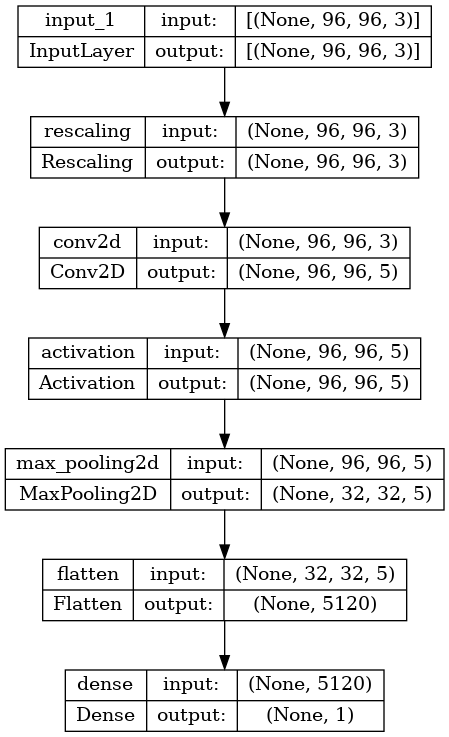

In [21]:
inputs = keras.Input(shape=(96, 96, 3))
x = layers.Rescaling(1.0 / 255)(inputs) # normalize image
x = layers.Conv2D(5, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(1, strides=3, padding="same")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

simple_cnn = keras.Model(inputs, outputs)

keras.utils.plot_model(simple_cnn, show_shapes=True)

In [22]:
simple_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 5)         140       
                                                                 
 activation (Activation)     (None, 96, 96, 5)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 5)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                             

As you can see, this simple model has 5,261 trainable parameters. Every thing is set up and ready to be trained. We will train for 30 epochs.

In [24]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
simple_cnn.compile(
    optimizer=keras.optimizers.SGD(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_simple_cnn = simple_cnn.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/30
2751/2751 [==============================] - 73s 26ms/step - loss: 0.4291 - accuracy: 0.8093 - val_loss: 0.4247 - val_accuracy: 0.8102
Epoch 2/30
2751/2751 [==============================] - 80s 29ms/step - loss: 0.4272 - accuracy: 0.8112 - val_loss: 0.5141 - val_accuracy: 0.7603
Epoch 3/30
2751/2751 [==============================] - 71s 26ms/step - loss: 0.4255 - accuracy: 0.8121 - val_loss: 0.4586 - val_accuracy: 0.8000
Epoch 4/30
2751/2751 [==============================] - 73s 26ms/step - loss: 0.4242 - accuracy: 0.8120 - val_loss: 0.4744 - val_accuracy: 0.7771
Epoch 5/30
2751/2751 [==============================] - 72s 26ms/step - loss: 0.4231 - accuracy: 0.8133 - val_loss: 0.4270 - val_accuracy: 0.8103
Epoch 6/30
2751/2751 [==============================] - 73s 26ms/step - loss: 0.4215 - accuracy: 0.8144 - val_loss: 0.5384 - val_accuracy: 0.7346
Epoch 7/30
2751/2751 [==============================] - 82s 30ms/step - loss: 0.4205 - accuracy: 0.8139 - val_loss: 0.4409 -

In [25]:
def plot_training_results(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

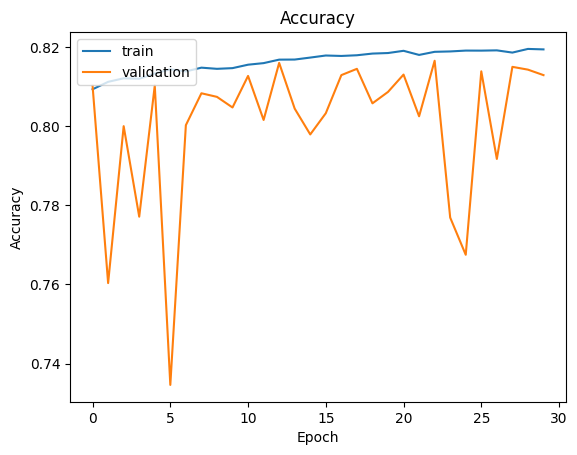

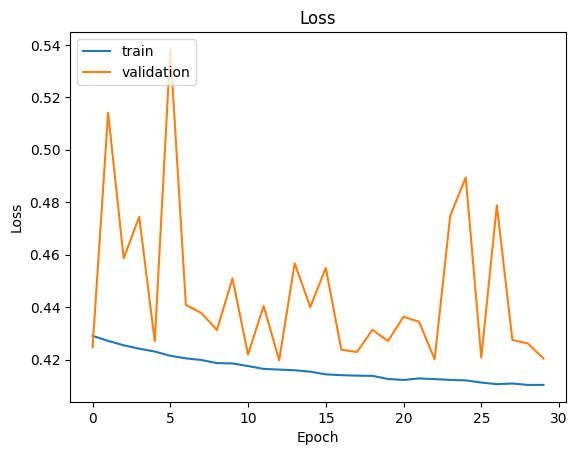

In [26]:
plot_training_results(history_simple_cnn)

As you can see by the above plots, the training accuracy goes up with each epoch and the training loss goes down with each epoch. Additionally, the validation accuracy and loss are sort of all over the place. This is to be expected with a dataset this large, and we are most interested in the epoch with the best validation accuracy performance. In this case, the best performance was obtained after epoch 23 with a validation accuracy of 0.8166.

### A Bigger CNN
Next, we will experiment with a larger CNN. This model will have 3 convolution layers, the first layer will have 32 filters, the second 64 filters, and the last 128 filters. Each filter will be 3x3x3. Each convolution layer will also be followed by relu activation and max pooling. Similar to our simple model, this model will feature a dense classifier with no hidden layers. I would expect this model to perform better than the previous model since it should be extracting much more information in the feature extraction phase. 

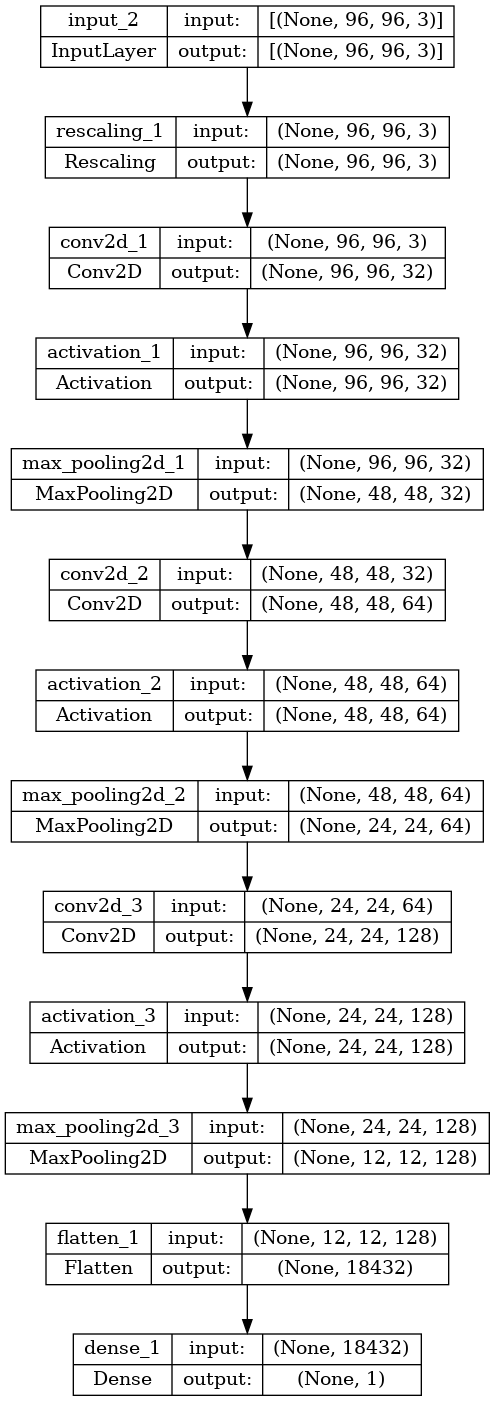

In [27]:
inputs = keras.Input(shape=(96, 96, 3))
x = layers.Rescaling(1.0 / 255)(inputs) # normalize image
x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

bigger_cnn = keras.Model(inputs, outputs)

keras.utils.plot_model(bigger_cnn, show_shapes=True)

In [28]:
bigger_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 activation_1 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        18496     
                                                           

As you can see, this model has 111,681 trainable parameters, which is over 20x larger than the previous model. We will again train for 30 epochs.

In [30]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
bigger_cnn.compile(
    optimizer=keras.optimizers.SGD(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_bigger_cnn = bigger_cnn.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/30
2751/2751 [==============================] - 82s 29ms/step - loss: 0.5044 - accuracy: 0.7541 - val_loss: 0.4595 - val_accuracy: 0.7856
Epoch 2/30
2751/2751 [==============================] - 86s 31ms/step - loss: 0.4302 - accuracy: 0.8061 - val_loss: 0.3928 - val_accuracy: 0.8279
Epoch 3/30
2751/2751 [==============================] - 90s 33ms/step - loss: 0.4020 - accuracy: 0.8228 - val_loss: 0.3773 - val_accuracy: 0.8376
Epoch 4/30
2751/2751 [==============================] - 89s 32ms/step - loss: 0.3853 - accuracy: 0.8324 - val_loss: 0.3782 - val_accuracy: 0.8325
Epoch 5/30
2751/2751 [==============================] - 89s 32ms/step - loss: 0.3718 - accuracy: 0.8393 - val_loss: 0.4215 - val_accuracy: 0.8103
Epoch 6/30
2751/2751 [==============================] - 83s 30ms/step - loss: 0.3616 - accuracy: 0.8452 - val_loss: 0.3467 - val_accuracy: 0.8513
Epoch 7/30
2751/2751 [==============================] - 80s 29ms/step - loss: 0.3519 - accuracy: 0.8499 - val_loss: 0.3587 -

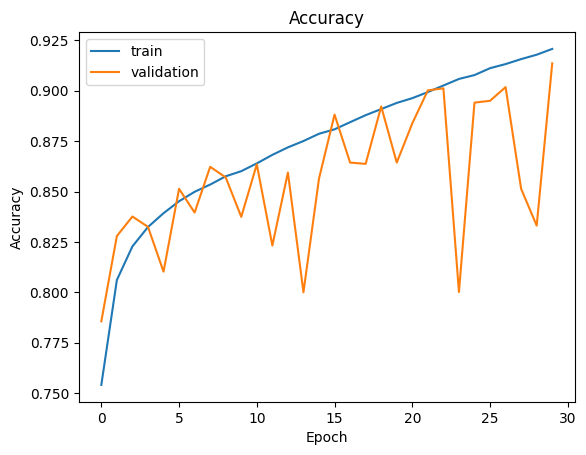

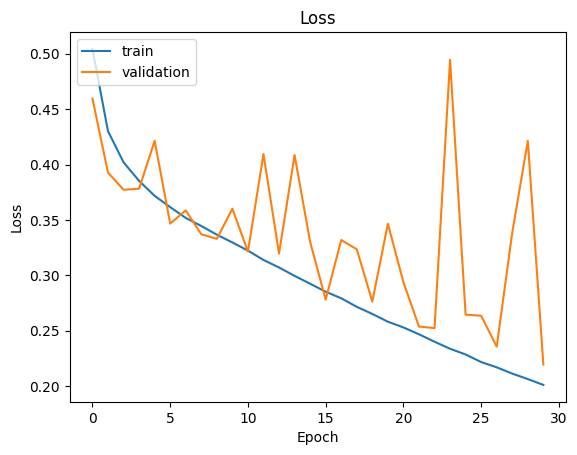

In [31]:
plot_training_results(history_bigger_cnn)

Once again, the training accuracy goes up with each epoch and the training loss goes down with each epoch. We are still most interested in the epoch with the best validation accuracy performance. In this case, the best performance was obtained after epoch 30 with a validation accuracy of 0.9136. This is a large improvement over the simple CNN that we experimented with first. Additionally, it is hard to say whether or not this model converged yet, as the best validation accuracy took place at the last epoch.

### Bigger CNN with Bigger Classifier
Next, we will turn our attention to a model with the same bigger feature extraction portion as before, but a larger classification head. The classifier features 3 hidden layers, with dropout taking place in between the first and second hidden layers. 

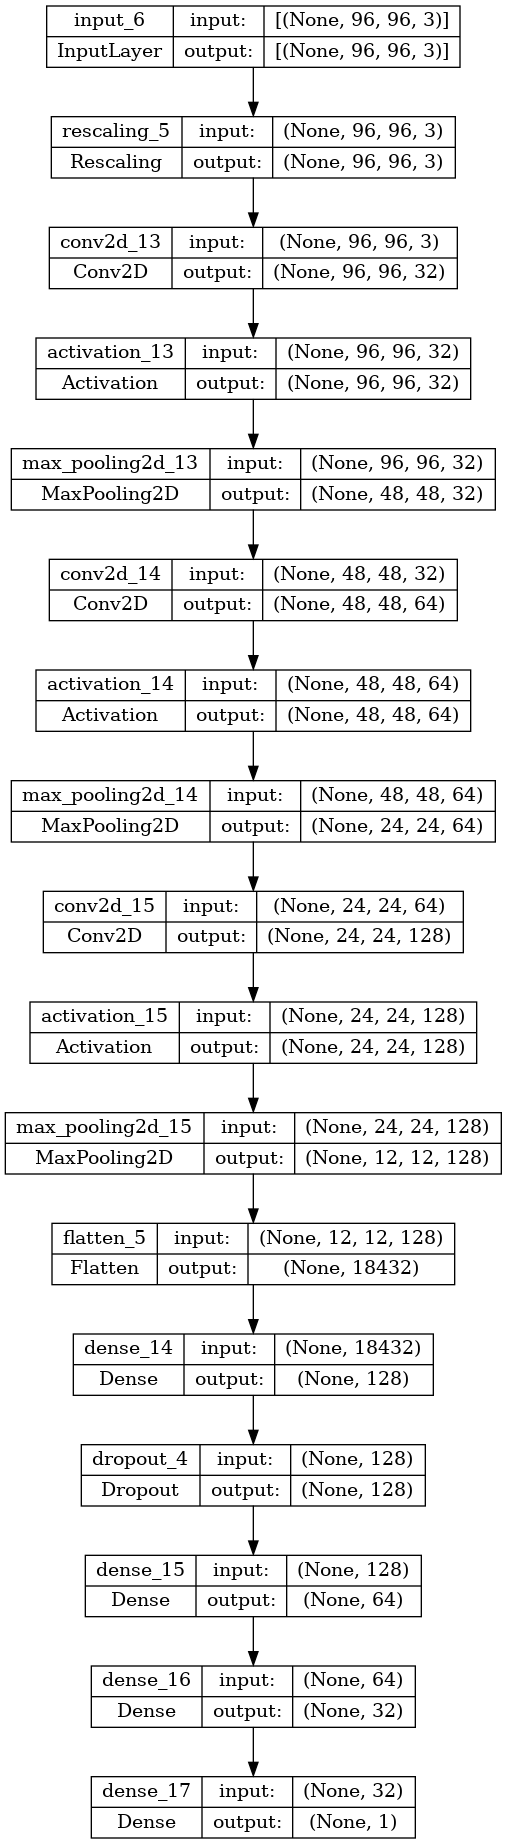

In [35]:
inputs = None
inputs = keras.Input(shape=(96, 96, 3))
x = layers.Rescaling(1.0 / 255)(inputs) # normalize image
x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

bigger_cnn_bigger_classifier = keras.Model(inputs, outputs)

keras.utils.plot_model(bigger_cnn_bigger_classifier, show_shapes=True)

In [36]:
bigger_cnn_bigger_classifier.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 activation_13 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 48, 48, 64)        18496     
                                                           

The large fully connected classifier causes the number of trainable parameters to increase significantly. We now have over 2.4 million trainable parameters, which is much larger than the 111,000 from the previous model. It is possible that this many trainable parameters could cause our model to overfit. 

In [37]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
bigger_cnn_bigger_classifier.compile(
    optimizer=keras.optimizers.SGD(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_bigger_cnn_bigger_classifier = bigger_cnn_bigger_classifier.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/30
2751/2751 [==============================] - 91s 33ms/step - loss: 0.5418 - accuracy: 0.7275 - val_loss: 0.4649 - val_accuracy: 0.7880
Epoch 2/30
2751/2751 [==============================] - 82s 30ms/step - loss: 0.4474 - accuracy: 0.7973 - val_loss: 0.4338 - val_accuracy: 0.8055
Epoch 3/30
2751/2751 [==============================] - 90s 33ms/step - loss: 0.4099 - accuracy: 0.8197 - val_loss: 0.4036 - val_accuracy: 0.8275
Epoch 4/30
2751/2751 [==============================] - 81s 29ms/step - loss: 0.3798 - accuracy: 0.8351 - val_loss: 0.3709 - val_accuracy: 0.8410
Epoch 5/30
2751/2751 [==============================] - 82s 30ms/step - loss: 0.3573 - accuracy: 0.8469 - val_loss: 0.4166 - val_accuracy: 0.8093
Epoch 6/30
2751/2751 [==============================] - 90s 33ms/step - loss: 0.3393 - accuracy: 0.8548 - val_loss: 0.4088 - val_accuracy: 0.8230
Epoch 7/30
2751/2751 [==============================] - 93s 34ms/step - loss: 0.3244 - accuracy: 0.8621 - val_loss: 0.3100 -

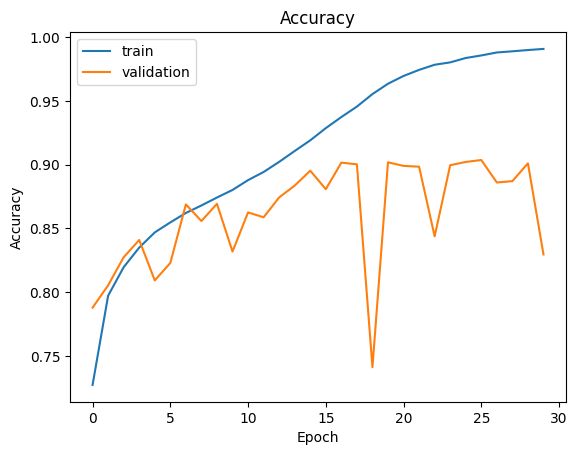

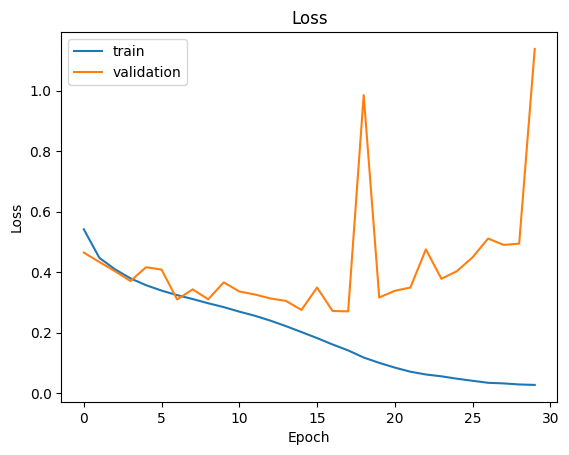

In [38]:
plot_training_results(history_bigger_cnn_bigger_classifier)

It does appear that we have overfit a bit. With both the accuracy and the loss, there is a clear turning point around epoch 15 where the validation scores begin to significantly deviate from the training scores. This is a tell tale sign that overfitting took place. That being said, we did obtain a decent validation accuracy of 0.9036 after epoch 26.

### Hyperparameter Tuning

It is clear from our experiments above that our best model is the larger CNN with the simple fully connected classifier. This model achieved the best results while still being relatively simple. In general, a simple model that performs the same as a more complicated model is preferable, but in this case, the model is both simpler and more accurate than the model with the more complicated classification head. 

There are many different things that can be tuned to try and improve performance, but given the limited GPU resources that are available to me, I can not conduct a full scale hyperparameter tuning job. Instead, I will experiment with a higher learning rate and see how that changes our results. 

In [ ]:
inputs = keras.Input(shape=(96, 96, 3))
x = layers.Rescaling(1.0 / 255)(inputs) # normalize image
x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

bigger_cnn_higher_lr = keras.Model(inputs, outputs)

epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
bigger_cnn_higher_lr.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_bigger_cnn_higher_lr = bigger_cnn_higher_lr.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/30
2751/2751 [==============================] - 90s 32ms/step - loss: 0.5267 - accuracy: 0.7319 - val_loss: 0.4251 - val_accuracy: 0.8072
Epoch 2/30
2751/2751 [==============================] - 89s 32ms/step - loss: 0.4088 - accuracy: 0.8173 - val_loss: 0.3550 - val_accuracy: 0.8460
Epoch 3/30
2751/2751 [==============================] - 82s 30ms/step - loss: 0.3522 - accuracy: 0.8489 - val_loss: 0.3484 - val_accuracy: 0.8512
Epoch 4/30
2751/2751 [==============================] - 91s 33ms/step - loss: 0.3214 - accuracy: 0.8642 - val_loss: 0.4122 - val_accuracy: 0.8036
Epoch 5/30
2751/2751 [==============================] - 89s 32ms/step - loss: 0.2906 - accuracy: 0.8794 - val_loss: 0.3135 - val_accuracy: 0.8767
Epoch 6/30
2751/2751 [==============================] - 89s 32ms/step - loss: 0.2633 - accuracy: 0.8922 - val_loss: 0.3246 - val_accuracy: 0.8648
Epoch 7/30
2751/2751 [==============================] - 88s 32ms/step - loss: 0.2405 - accuracy: 0.9029 - val_loss: 0.2931 -

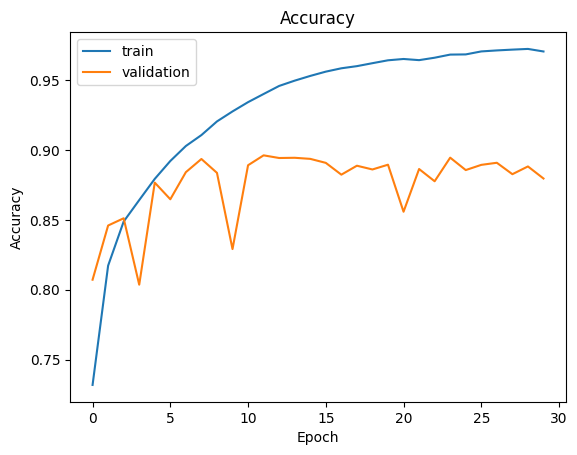

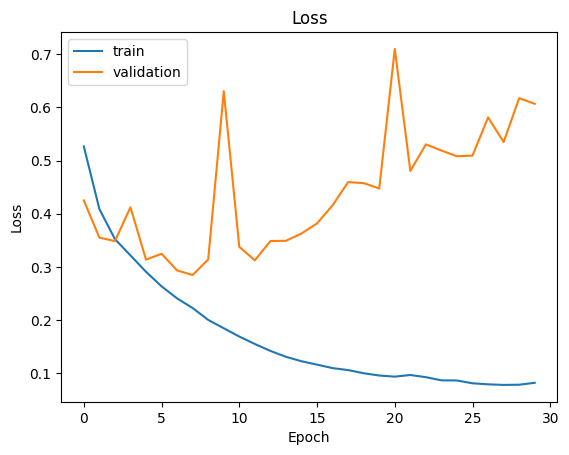

In [43]:
plot_training_results(history_bigger_cnn_higher_lr)

As you can see, the higher learning rate caused the training performance to get worse. There appears to be a clear overfitting that begins at epoch 7. From that point on, the validation loss is on an upward trajectory. 

Given more time, it would be valuable to tune other parameters such as different values for learning rate, momentum, the specific loss function, the specific optimizer, etc. However, conducting a full scale hyperparameter tuning job for a neural network can be computationally expensive, and I will have to move forward with my best performing model. 

## Results and Analysis
The following table summarizes the results from our experiments so far. 

| Model                             | Validation Acc | Trainable Params |
|-----------------------------------|----------------|------------------|
| Simple CNN                        | 0.8166         | 5,261            |
| **Bigger CNN**                    | 0.9136         | 111,681          |
| Bigger CNN with Bigger Classifier | 0.9036         | 2,463,041        |
| Bigger CNN with Higher LR         | 0.8909         | 111,681          |

It is clear that our 2nd experiment with the bigger cnn is our best performing model. This model was able to extact the needed infomation with 3 convolutional layers and a very simple dense classifier. We will now take this best performing model and make predictions on the test dataset to submit to kaggle.

### Test Dataset

We will begin by formatting the dataset in the same way that the training and validation datasets were formatted. 

In [32]:
os.mkdir('/kaggle/working/test_data/')

In [33]:
test_imgs = os.listdir('/kaggle/input/histopathologic-cancer-detection/test/')
for name in tqdm.tqdm(test_imgs):
    img = cv2.imread('/kaggle/input/histopathologic-cancer-detection/test/{}'.format(name))
    cv2.imwrite('/kaggle/working/test_data/{}'.format(name.replace('.tif', '.jpg')), img)

100%|██████████| 57458/57458 [01:14<00:00, 768.18it/s]


In [34]:
test_jpgs = os.listdir('/kaggle/working/test_data/')
print(len(test_jpgs))

57458


There are 57,458 test images. To make predictions on these images, we will load in our saved best model from a .keras file that was saved during training. 

In [35]:
inputs = keras.Input(shape=(96, 96, 3))
x = layers.Rescaling(1.0 / 255)(inputs) # normalize image
x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(128, 3, strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

best_model = keras.Model(inputs, outputs)

best_model.load_weights('/kaggle/input/best-model/best_model.keras')

Since making the predictions one image at a time would be very time consuming, we will make the predictions in batches of 64. This allows the prediction process to happen quicker while limiting the amount of prediction stored in RAM. 

In [37]:
#test_imgs = os.listdir('/kaggle/input/histopathologic-cancer-detection/test/')
test_imgs = os.listdir('/kaggle/working/test_data/')
batches = []
batch = []
img_names = []
image_size = (96, 96)
all_results = []
all_images = []

for test_img in tqdm.tqdm(test_imgs):
    img = keras.preprocessing.image.load_img("/kaggle/working/test_data/{}".format(test_img), target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    
    batch.append(img_array)
    img_names.append(test_img.replace('.jpg', ''))
    
    if len(batch) == 64:
        batch = tf.stack(batch)
        predictions = best_model.predict_on_batch(batch)
        
        all_results.extend(predictions)
        all_images.extend(img_names)
        
        batch = []
        img_names = []

# do final batch
batch = tf.stack(batch)
print(batch.shape)
predictions = best_model.predict_on_batch(batch)
all_results.extend(predictions)
all_images.extend(img_names)

100%|██████████| 57458/57458 [18:10<00:00, 52.69it/s]


(50, 96, 96, 3)


In [38]:
len(all_images)

57458

The activation function applied at the end is a sigmoid function, so each prediction is a value between 0 and 1. We need to convert this to 0s and 1s so that we can submit our predictions.

In [39]:
all_results_int = [1 if float(x[0]) >= 0.5 else 0 for x in all_results]

In [40]:
fixed_names = [x.replace('.tif', '') for x in all_images]

In [41]:
submission = pd.DataFrame(fixed_names, columns=['id'])
submission['label'] = all_results_int

In [42]:
submission.head()

,id,label
0,e4dc2c6981c198ed93293b9c6c7dc8f6b5e2a06d,0
1,1d045109b6c7d84e9e3212c39dd26827e22ec926,0
2,374c83c6381b3a966dca83f13e5119b69357115f,1
3,0f87dcff888fa91ce97b8363216f7425c4b4de23,0
4,0857844ffe33caac6cf7d75a66d15c1caf6a3598,0


In [43]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

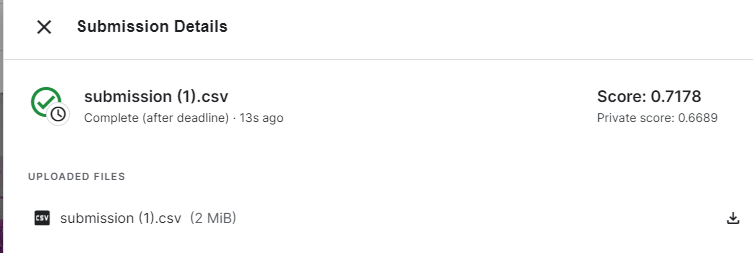

As you can see, we achieved a 0.7178 performance on the public kaggle test set. This is pretty good, but indicates that our model overfit slightly to the validation dataset, since this performance is much lower. 

## Conclusion

This competition was a great chance for me to learn about building convolutional neural networks from scratch. While my score is not at the top of the leaderboard, I now have a much better understanding of using Keras to build models from the ground up. 

In my experiments, I found that I needed to strike a balance between complexity and overfitting. In the end, I found that a more complicated set of convolutions with a simple classification head was the balance that delivered the best results. 

There are a handful of improvements that I would love to experiment with given the time. They can be seen below:
* Experiment with different loss functions and optimizers
* Experiment with a state of the art image classification model on tf.hub
* Experiment with augmentations during training and test time augmentations at inference